## 9. Analysis of Network Flow Data

#### 2015년 4월 10일 최창순

In [45]:
install.packages("sand")

Warning message:
: unable to access index for repository http://cran.nexr.com/bin/macosx/mavericks/contrib/3.1Warning message:
: package ‘sand’ is not available (as a binary package for R version 3.1.3)

In [2]:
library(sand)

Loading required package: igraph
Loading required package: igraphdata

Statistical Analysis of Network Data with R
Type in C2 (+ENTER) to start with Chapter 2.


In [3]:
data(calldata)

## 9.2. Modeling Network Flows

## 중력 모형 (Gravity model)

뉴턴의 만유 인력의 법칙을 원용한 것으로, 물체의 질량 대신 지역의 인구 규모로 대체하여 두 지역 간의 상호 작용 관계를 설명하려는 수식으로, 공간적 상호 작용 모형이라고도 한다. 두 지역 간의 유통량을 측정하는 방법으로서 중력 모형의 기본 원리는 지역의 인구 규모에 비례하고 거리의 제곱에 반비례한다는 것이다. 즉 유통량은 두 지역 간의 인구 규모가 클수록 늘어나고 거리가 멀어질수록 줄어든다는 것이다. 이 모형은 교통량을 예측하고 교통 계획을 세우는 데 활용되며, 이 밖에 인구 이동 연구에도 쓰인다. 중력 모형에 의하여 계산한 유통의 양과 실제 유통량의 차이는 두 지역 간의 유통 방해 요인이 작용하기 때문이다. 수식으로 표현하면 다음과 같다.

- lab = K x Pa x Pb / Dab^2

(단, Iab는 ab 지역 간의 유통량, Pa · Pb는 a, b 지역의 인구 규모, Dab는 a, b 지역 간의 거리, K는 상수)


뉴턴의 만유인력의 법칙
http://ko.wikipedia.org/wiki/%EB%A7%8C%EC%9C%A0%EC%9D%B8%EB%A0%A5%EC%9D%98_%EB%B2%95%EC%B9%99

### 1. Model specification
- phone traffic data in austria (1991 year)

In [4]:
names(calldata)

[1] "Orig"    "Dest"    "DistEuc" "DistRd"  "O.GRP"   "D.GRP"   "Flow"   

- GRP (Gross Regional Products, 지역내총생산)

시도별 GDP(gross domestic product:국내총생산)라고 할 수도 있는데, GRDP가 GDP를 단순히 지역별로 배분한 것은 아니며, 이용기초자료와 접근방법의 차이로 인하여 GRDP의 합계와 GDP가 반드시 일치하지 않는다. GRDP에는 지역배분이 곤란한 국방부문 생산액과 수입관세 등은 포함되지 않으며, 또한 발생된 소득이 시도간 이전을 통해 최종적으로 어느 시도의 주민에게 귀속되는가를 나타내는 분배 측면의 소득과는 다소 차이가 있다. 예를 들면 서울 사람이 부산에 있는 사업체에서 근무할 경우 직장에서 생산하는 재화나 용역은 서울이 아닌 부산지역 지역총생산으로 된다. 따라서 GRDP의 전국 합계액은 기초자료가 달라짐에 따라 3∼5％의 차이가 발생한다.

- DistRd : Road based distance

In [5]:
str(calldata)

'data.frame':	992 obs. of  7 variables:
 $ Orig   : Factor w/ 32 levels "Amstetten","BadIschl",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Dest   : Factor w/ 32 levels "Amstetten","BadIschl",..: 27 20 30 25 32 10 8 9 16 12 ...
 $ DistEuc: num  36.1 61.5 46.5 88.6 135.1 ...
 $ DistRd : int  37 81 56 96 145 85 187 132 212 212 ...
 $ O.GRP  : int  7828880 7828880 7828880 7828880 7828880 7828880 7828880 7828880 7828880 7828880 ...
 $ D.GRP  : int  285193984 7685130 27369776 24601360 8143690 6385840 58493328 11338860 8395990 9453630 ...
 $ Flow   : num  57.61 1.4 19.91 3.91 1.39 ...


In [6]:
head(calldata)

      Orig         Dest DistEuc DistRd   O.GRP     D.GRP     Flow
1 Bruck/Le         Wien   36.14     37 7828880 285193984 57.61270
2 Bruck/Le   Mistelbach   61.46     81 7828880   7685130  1.39963
3 Bruck/Le  Wr.Neustadt   46.50     56 7828880  27369776 19.90791
4 Bruck/Le St.P\xbalten   88.60     96 7828880  24601360  3.90906
5 Bruck/Le       Zwettl  135.13    145 7828880   8143690  1.38712
6 Bruck/Le   Hollabrunn   78.75     85 7828880   6385840  1.49779

- Flow column : units of erlang
- erlang(얼랑) : 1회선을 1시간 관측했을 때 1시간 전부가 사용 중인 호량이다. 또는 임의의 회선군을 임의의 시각에 관측했을 때 5회선만 사용 중이면 그 시각의 호량은 5얼랑이다 (IT용어사전, 한국정보통신기술협회)

In [7]:
min.call <- min(calldata$Flow)
calldata$FlowCnt <- round(5 * calldata$Flow / min.call)

In [8]:
head(calldata)

      Orig         Dest DistEuc DistRd   O.GRP     D.GRP     Flow FlowCnt
1 Bruck/Le         Wien   36.14     37 7828880 285193984 57.61270  112525
2 Bruck/Le   Mistelbach   61.46     81 7828880   7685130  1.39963    2734
3 Bruck/Le  Wr.Neustadt   46.50     56 7828880  27369776 19.90791   38883
4 Bruck/Le St.P\xbalten   88.60     96 7828880  24601360  3.90906    7635
5 Bruck/Le       Zwettl  135.13    145 7828880   8143690  1.38712    2709
6 Bruck/Le   Hollabrunn   78.75     85 7828880   6385840  1.49779    2925

In [9]:
which(calldata$FlowCnt == 5)

[1] 983

In [10]:
calldata[983,]

         Orig   Dest DistEuc DistRd   O.GRP   D.GRP    Flow FlowCnt
983 Freistadt Reutte   303.3    388 2310400 3349500 0.00256       5

In [11]:
W <- xtabs(FlowCnt ~ Orig + Dest , calldata) ## xtabs 좋은데?

In [12]:
W

              Dest
Orig           Amstetten BadIschl Bischofsh. Bruck/Le Bruck/Mur Feldkirch
  Amstetten            0     4222       6731      640      7235      6342
  BadIschl          2514        0       3695     1184      2981      2192
  Bischofsh.        3113     3812          0     1095      5807      4926
  Bruck/Le          2812     1137       1902        0      2715      3865
  Bruck/Mur         7485     5337       7184      842         0     14447
  Feldkirch         3304      850        774     7593     71570         0
  Freistadt         3338     1067        302       68       539      1266
  Graz              7222     8239       9395     4288    253436     23995
  Hartberg          5194     1216       2296    11134     13308      5957
  Hollabrunn        6462      471        853     2540      1320      2278
  Innsbruck         7543     3751       9620     2079     20574     74524
  Judenburg          551      666       1383      214      5836      1294
  Kirch/Krems      

In [13]:
g.cd <- graph.adjacency(W, weighted = TRUE)

In [14]:
V(g.cd)

Vertex sequence:
 [1] "Amstetten"    "BadIschl"     "Bischofsh."   "Bruck/Le"     "Bruck/Mur"   
 [6] "Feldkirch"    "Freistadt"    "Graz"         "Hartberg"     "Hollabrunn"  
[11] "Innsbruck"    "Judenburg"    "Kirch/Krems"  "Klagenfurt"   "Landeck"     
[16] "Leibnitz"     "Lienz/Os"     "Liezen"       "Linz"         "Mistelbach"  
[21] "Reutte"       "Ried/Inn"     "Salzburg"     "Sp/Drau"      "St.P\xbalten"  
[26] "V\xbacklabruck" "Wien"         "Wolfsberg"    "W\xbargl"       "Wr.Neustadt" 
[31] "ZellamSee"    "Zwettl"      

In [15]:
E(g.cd)

Edge sequence:
                                      
[1]       Amstetten    -> BadIschl    
[2]       Amstetten    -> Bischofsh.  
[3]       Amstetten    -> Bruck/Le    
[4]       Amstetten    -> Bruck/Mur   
[5]       Amstetten    -> Feldkirch   
[6]       Amstetten    -> Freistadt   
[7]       Amstetten    -> Graz        
[8]       Amstetten    -> Hartberg    
[9]       Amstetten    -> Hollabrunn  
[10]      Amstetten    -> Innsbruck   
[11]      Amstetten    -> Judenburg   
[12]      Amstetten    -> Kirch/Krems 
[13]      Amstetten    -> Klagenfurt  
[14]      Amstetten    -> Landeck     
[15]      Amstetten    -> Leibnitz    
[16]      Amstetten    -> Lienz/Os    
[17]      Amstetten    -> Liezen      
[18]      Amstetten    -> Linz        
[19]      Amstetten    -> Mistelbach  
[20]      Amstetten    -> Reutte      
[21]      Amstetten    -> Ried/Inn    
[22]      Amstetten    -> Salzburg    
[23]      Amstetten    -> Sp/Drau     
[24]    Amstetten    -> St.P\xbalten  
[25]    Am

In [16]:
in.flow <- graph.strength(g.cd, mode="in")
out.flow <- graph.strength(g.cd, mode="out")
vsize <- sqrt(in.flow + out.flow) / 100
pie.vals <- lapply((1:vcount(g.cd)), function(i) c(in.flow[i], out.flow[i]))
ewidth <- E(g.cd)$weight / 10^5

In [17]:
in.flow

   Amstetten     BadIschl   Bischofsh.     Bruck/Le    Bruck/Mur    Feldkirch 
      513914       199864       406802       269720       727321       557543 
   Freistadt         Graz     Hartberg   Hollabrunn    Innsbruck    Judenburg 
      152198      1675166       470552       298649       463261       339780 
 Kirch/Krems   Klagenfurt      Landeck     Leibnitz     Lienz/Os       Liezen 
      170674       569176       135914       390192       166341       268754 
        Linz   Mistelbach       Reutte     Ried/Inn     Salzburg      Sp/Drau 
     1130720       251069        60236       472594       446054       176317 
  St.P\xbalten V\xbacklabruck         Wien    Wolfsberg       W\xbargl  Wr.Neustadt 
      825491       566993      3013009       105932       370366       861401 
   ZellamSee       Zwettl 
      240019       328523 

In [18]:
out.flow

   Amstetten     BadIschl   Bischofsh.     Bruck/Le    Bruck/Mur    Feldkirch 
      246721       197223       195801       229675       212461       541056 
   Freistadt         Graz     Hartberg   Hollabrunn    Innsbruck    Judenburg 
      135781      1389074       408284       222149       737851        89011 
 Kirch/Krems   Klagenfurt      Landeck     Leibnitz     Lienz/Os       Liezen 
      213790       635808        81761       220720       107969       316759 
        Linz   Mistelbach       Reutte     Ried/Inn     Salzburg      Sp/Drau 
     1484079       125378       203136       380418      1749360       241332 
  St.P\xbalten V\xbacklabruck         Wien    Wolfsberg       W\xbargl  Wr.Neustadt 
      670356       266794      3574329       117425       806704       378515 
   ZellamSee       Zwettl 
      137257       307568 

In [19]:
vsize

   Amstetten     BadIschl   Bischofsh.     Bruck/Le    Bruck/Mur    Feldkirch 
    8.721439     6.301484     7.762751     7.066789     9.694235    10.481407 
   Freistadt         Graz     Hartberg   Hollabrunn    Innsbruck    Judenburg 
    5.366367    17.504971     9.374625     7.216634    10.959526     6.548213 
 Kirch/Krems   Klagenfurt      Landeck     Leibnitz     Lienz/Os       Liezen 
    6.200516    10.977176     4.665565     7.816086     5.237461     7.651882 
        Linz   Mistelbach       Reutte     Ried/Inn     Salzburg      Sp/Drau 
   16.170340     6.135528     5.131978     9.235865    14.816930     6.462577 
  St.P\xbalten V\xbacklabruck         Wien    Wolfsberg       W\xbargl  Wr.Neustadt 
   12.230482     9.131194    25.665810     4.726066    10.849286    11.135152 
   ZellamSee       Zwettl 
    6.142280     7.975531 

In [20]:
pie.vals

[[1]]
Amstetten Amstetten 
   513914    246721 

[[2]]
BadIschl BadIschl 
  199864   197223 

[[3]]
Bischofsh. Bischofsh. 
    406802     195801 

[[4]]
Bruck/Le Bruck/Le 
  269720   229675 

[[5]]
Bruck/Mur Bruck/Mur 
   727321    212461 

[[6]]
Feldkirch Feldkirch 
   557543    541056 

[[7]]
Freistadt Freistadt 
   152198    135781 

[[8]]
   Graz    Graz 
1675166 1389074 

[[9]]
Hartberg Hartberg 
  470552   408284 

[[10]]
Hollabrunn Hollabrunn 
    298649     222149 

[[11]]
Innsbruck Innsbruck 
   463261    737851 

[[12]]
Judenburg Judenburg 
   339780     89011 

[[13]]
Kirch/Krems Kirch/Krems 
     170674      213790 

[[14]]
Klagenfurt Klagenfurt 
    569176     635808 

[[15]]
Landeck Landeck 
 135914   81761 

[[16]]
Leibnitz Leibnitz 
  390192   220720 

[[17]]
Lienz/Os Lienz/Os 
  166341   107969 

[[18]]
Liezen Liezen 
268754 316759 

[[19]]
   Linz    Linz 
1130720 1484079 

[[20]]
Mistelbach Mistelbach 
    251069     125378 

[[21]]
Reutte Reutte 
 60236 203136 

[[2

In [21]:
ewidth

  [1] 0.04222 0.06731 0.00640 0.07235 0.06342 0.07160 0.10389 0.03950 0.00522
 [10] 0.04346 0.02610 0.04186 0.06767 0.00715 0.01883 0.01452 0.09408 0.92097
 [19] 0.04455 0.01054 0.08286 0.06356 0.02365 0.02761 0.10190 0.24920 0.00692
 [28] 0.02937 0.06439 0.03218 0.02393 0.02514 0.03695 0.01184 0.02981 0.02192
 [37] 0.00990 0.13802 0.01194 0.00620 0.03363 0.02232 0.03083 0.02640 0.00512
 [46] 0.01095 0.00715 0.05157 0.28618 0.00338 0.00196 0.06619 0.16401 0.00653
 [55] 0.03132 0.42022 0.43925 0.00264 0.01681 0.02968 0.01771 0.00666 0.03113
 [64] 0.03812 0.01095 0.05807 0.04926 0.00649 0.17626 0.02259 0.01195 0.06711
 [73] 0.06011 0.01165 0.11946 0.01172 0.02378 0.01826 0.11635 0.14742 0.00844
 [82] 0.00556 0.07667 0.43725 0.06740 0.04770 0.07043 0.12277 0.01915 0.05585
 [91] 0.04153 0.00811 0.01647 0.02812 0.01137 0.01902 0.02715 0.03865 0.00261
[100] 0.08717 0.07369 0.02925 0.02246 0.01486 0.00836 0.04012 0.00773 0.01339
[109] 0.01795 0.01006 0.07268 0.02734 0.00413 0.01890 0.02363 0.

Warning message:
In text.default(x, y, labels = labels, col = label.color, family = label.family, : conversion failure on 'St.P<ba>lten' in 'mbcsToSbcs': dot substituted for <ba>Warning message:
In text.default(x, y, labels = labels, col = label.color, family = label.family, : conversion failure on 'V<ba>cklabruck' in 'mbcsToSbcs': dot substituted for <ba>Warning message:
In text.default(x, y, labels = labels, col = label.color, family = label.family, : conversion failure on 'W<ba>rgl' in 'mbcsToSbcs': dot substituted for <ba>

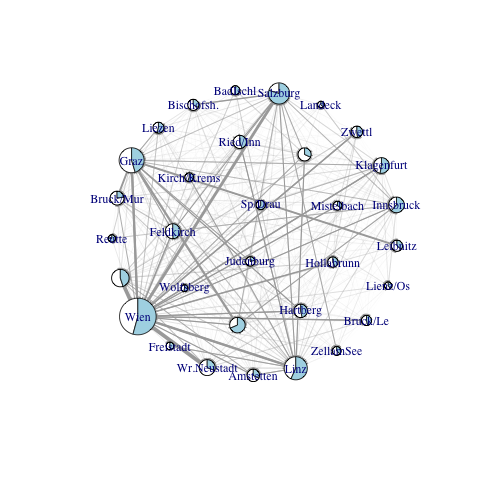

In [22]:
plot(g.cd, vertex.size = vsize, vertex.shape="pie", vertex.pie=pie.vals, 
    edge.width=ewidth, edge.arrow.size=0.1)

In [23]:
calldata$lFlowCnt <- log(calldata$FlowCnt, 10)
calldata$lO.GRP <- log(calldata$O.GRP, 10)
calldata$lD.GRP <- log(calldata$D.GRP, 10)
calldata$lDistRd <- log(calldata$DistRd, 10)

In [24]:
library(car)

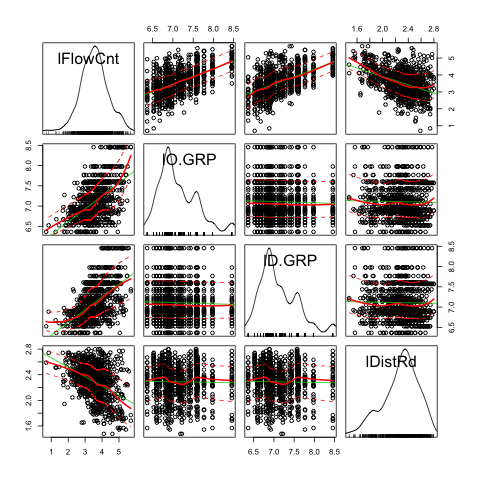

In [25]:
scatterplotMatrix( ~ lFlowCnt + lO.GRP + lD.GRP + lDistRd, data = calldata)

### 2. Inference for Gravity models

In [26]:
formula.s <- FlowCnt ~ lO.GRP + lD.GRP + lDistRd

In [27]:
formula.g <- FlowCnt ~ Orig + Dest + lDistRd

In [28]:
gm.s <- glm(formula.s, family="poisson", data = calldata)
summary(gm.s)


Call:
glm(formula = formula.s, family = "poisson", data = calldata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-475.06   -54.16   -29.20    -2.09  1149.93  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.149e+01  5.394e-03   -2131   <2e-16 ***
lO.GRP       1.885e+00  4.306e-04    4376   <2e-16 ***
lD.GRP       1.670e+00  4.401e-04    3794   <2e-16 ***
lDistRd     -2.191e+00  7.909e-04   -2770   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 45490237  on 991  degrees of freedom
Residual deviance: 10260808  on 988  degrees of freedom
AIC: 10270760

Number of Fisher Scoring iterations: 5


In [29]:
gm.g <- glm(formula.g, family="poisson", data = calldata)

In [30]:
summary(gm.g)


Call:
glm(formula = formula.g, family = "poisson", data = calldata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-381.90   -39.57   -13.99    15.93   707.67  

Coefficients:
                     Estimate Std. Error   z value Pr(>|z|)    
(Intercept)        14.3894809  0.0031027  4637.754  < 2e-16 ***
OrigBadIschl       -0.0169640  0.0030291    -5.600 2.14e-08 ***
OrigBischofsh.      0.1254566  0.0030417    41.246  < 2e-16 ***
OrigBruck/Le       -0.5425395  0.0029362  -184.774  < 2e-16 ***
OrigBruck/Mur      -0.1868560  0.0029710   -62.894  < 2e-16 ***
OrigFeldkirch       2.2032538  0.0024984   881.864  < 2e-16 ***
OrigFreistadt      -0.5370553  0.0033830  -158.752  < 2e-16 ***
OrigGraz            1.9702149  0.0022051   893.472  < 2e-16 ***
OrigHartberg        0.5079373  0.0025630   198.184  < 2e-16 ***
OrigHollabrunn     -0.3204144  0.0029422  -108.902  < 2e-16 ***
OrigInnsbruck       1.9121851  0.0023653   808.449  < 2e-16 ***
OrigJudenburg      -0.9123631  0.0

In [31]:
gm.g$fitted.values

           1            2            3            4            5            6 
161244.35112   2438.38837  11424.83891   6410.38764   2152.08415   2636.42057 
           7            8            9           10           11           12 
 10069.01378   3419.85869   1514.62847   1415.69505    922.36983   4102.98552 
          13           14           15           16           17           18 
  2300.82206    382.08960    535.45269    458.52999    979.86775    787.05741 
          19           20           21           22           23           24 
   224.26233   1645.83242    121.18530    468.11737   1283.45251    848.71929 
          25           26           27           28           29           30 
   526.14673   5206.74270   2494.65718    513.69213   1355.35603   1253.94273 
          31           32           33           34           35           36 
   538.05167 197842.12316 166456.34432 539770.20613 450416.86988 120224.99326 
          37           38           39           40 

In [32]:
gm.g$aic ## aic = Akaike information criterion

[1] 5466814

In [33]:
gm.s$aic

[1] 10270760

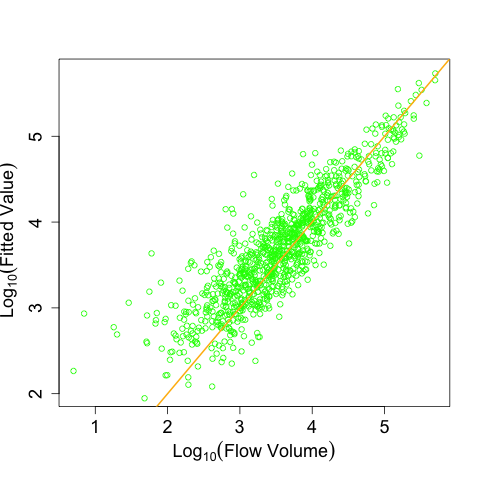

In [34]:
plot(calldata$lFlowCnt, log(gm.g$fitted.values, 10), cex.lab = 1.5, 
     xlab = expression(Log[10](paste("Flow Volume"))), col = "green", 
     cex.axis=1.5, ylab="", ylim=c(2, 5.75))
mtext(expression(Log[10](paste("Fitted Value"))), 2, outer=T, cex=1.5, padj=1)
abline(0, 1, lwd=2, col="darkgoldenrod1")

In [35]:
res <- residuals.glm(gm.g, type = "response")
relres <- res/calldata$FlowCnt
lrelres <- log(abs(relres), 10)
res.sgn <- (relres >= 0)

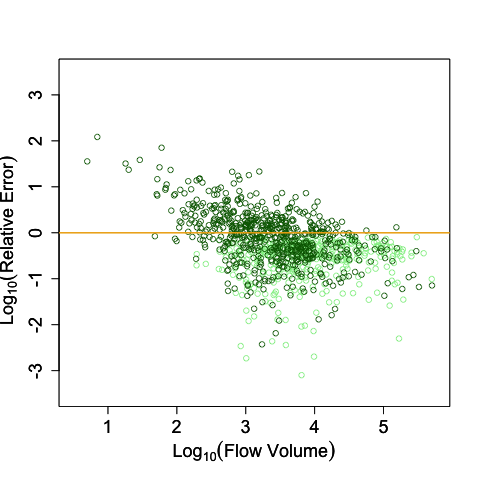

In [37]:
plot(calldata$lFlowCnt[res.sgn], lrelres[res.sgn], xlim = c(0.5, 5.75), ylim = c(-3.5, 3.5), 
    xlab = expression(Log[10](paste("Flow Volume"))), cex.lab = 1.5, cex.axis = 1.5, ylab = "",
    col = "lightgreen")
mtext(expression(Log[10](paste("Relative Error"))), 2, outer = T, cex=1.5, padj=1)
par(new=T)
plot(calldata$lFlowCnt[!res.sgn], lrelres[!res.sgn], xlim = c(0.5, 5.75), ylim = c(-3.5, 3.5), 
    xlab = expression(Log[10](paste("Flow Volume"))), cex.lab = 1.5, cex.axis = 1.5, ylab = "",
    col = "darkgreen")
mtext(expression(Log[10](paste("Relative Error"))), 2, outer = T, cex=1.5, padj=1)
abline(h=0, lwd=2, col="darkgoldenrod2")

### 잠깐 쉬어가기 - 패키지 설치 도전기 - 

In [1]:
install.packages("networkTomography") ### 헉!!!!! 왜 설치가 안되지....

Warning message:
: dependency ‘Rglpk’ is not available


The downloaded binary packages are in
	/var/folders/jm/lccyf0ts1_z5sgn7_v31yyph0000gn/T//Rtmpe308CW/downloaded_packages


In [2]:
library(networkTomography)

ERROR: Error: package or namespace load failed for ‘networkTomography’


### 아놔....
http://mirrors.nic.cz/R/web/checks/check_results_Rglpk.html

패키지 컴파일 고고


cschoiui-MacBook-Pro:etc neurochoi$ R CMD INSTALL Rglpk_0.6-0.tar.gz 
installing to library ‘/Library/Frameworks/R.framework/Versions/3.1/Resources/library’
ERROR: dependency ‘slam’ is not available for package ‘Rglpk’
removing ‘/Library/Frameworks/R.framework/Versions/3.1/Resources/library/Rglpk’

헐.......

In [1]:
install.packages("slam")


The downloaded binary packages are in
	/var/folders/jm/lccyf0ts1_z5sgn7_v31yyph0000gn/T//RtmpcVJuV1/downloaded_packages


In [1]:
install.packages("networkTomography")


The downloaded binary packages are in
	/var/folders/jm/lccyf0ts1_z5sgn7_v31yyph0000gn/T//RtmpCDHoeo/downloaded_packages


In [38]:
library(networkTomography) ## 된다!!!!!!!!

## 9.3. Predicting Network Flows

In [39]:
data(bell.labs)

In [40]:
g.bl <- graph.formula(fddi:switch:local:corp ++ Router)

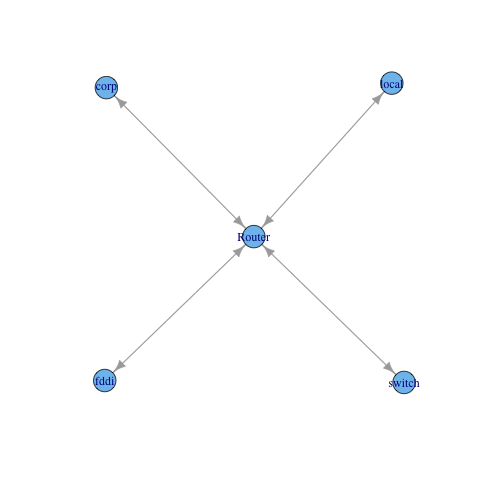

In [41]:
plot(g.bl)

In [42]:
B <- bell.labs$A
Z <- bell.labs$X
x <- bell.labs$Y

In [43]:
str(bell.labs)

List of 5
 $ A   : num [1:7, 1:16] 1 0 0 0 1 0 0 1 0 0 ...
 $ df  :'data.frame':	7175 obs. of  8 variables:
  ..$ value : num [1:7175] 0.00 9.66e+01 3.98e+04 2.83e-01 4.37e+02 ...
  ..$ nme   : Factor w/ 25 levels "corp->corp","corp->fddi",..: 10 12 11 9 22 24 23 21 14 16 ...
  ..$ method: Factor w/ 1 level "obs": 1 1 1 1 1 1 1 1 1 1 ...
  ..$ time  : Factor w/ 287 levels "(02/22/99 00:02:43)",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ od    : int [1:7175] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ orig  : Factor w/ 5 levels "all","corp","fddi",..: 3 3 3 3 5 5 5 5 4 4 ...
  ..$ dest  : Factor w/ 5 levels "all","corp","fddi",..: 3 5 4 2 3 5 4 2 3 5 ...
  ..$ node  : Factor w/ 6 levels "","all","corp",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ X   : num [1:287, 1:16] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ time: chr [1:287] "0.0452777777777778" "0.128888888888889" "0.212222222222222" "0.295277777777778" ...
  .. ..$     : chr [1:16] "1" "2" "3" "4" ...
 $ Y   : num [1:287, 1:7] 39922 41314 37

In [44]:
head(bell.labs)

$A
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
[1,]    1    1    1    1    0    0    0    0    0     0     0     0     0     0
[2,]    0    0    0    0    1    1    1    1    0     0     0     0     0     0
[3,]    0    0    0    0    0    0    0    0    1     1     1     1     0     0
[4,]    0    0    0    0    0    0    0    0    0     0     0     0     1     1
[5,]    1    0    0    0    1    0    0    0    1     0     0     0     1     0
[6,]    0    1    0    0    0    1    0    0    0     1     0     0     0     1
[7,]    0    0    1    0    0    0    1    0    0     0     1     0     0     0
     [,15] [,16]
[1,]     0     0
[2,]     0     0
[3,]     0     0
[4,]     1     1
[5,]     0     0
[6,]     0     0
[7,]     1     0

$df
            value            nme method                time od   orig   dest
1    0.000000e+00     fddi->fddi    obs (02/22/99 00:02:43)  1   fddi   fddi
2    9.659259e+01   fddi->switch    obs (02/22/99 00:02:43)  1

In [38]:
library(lattice)

In [39]:
traffic.in <- c("dst fddi", "dst switch", "dst local", "dst corp")
traffic.out <- c("src fddi", "src switch", "src local", "src corp")
my.df <- bell.labs$df
my.df$t <- unlist(lapply(my.df$time, function(x) {
    hrs <- as.numeric(substring(x, 11, 12))
    mins <- as.numeric(substring(x, 14, 15))
    t <- hrs + mins/60
    return(t)}))

In [40]:
# Separate according to whether data are incoming or outgoing.
my.df.in <- subset(my.df, nme %in% traffic.in)
my.df.out <- subset(my.df, nme %in% traffic.out)

In [42]:
# Set up trellis plots for each case.
p.in <- xyplot(value / 2^10 ~ t | nme, data=my.df.in, type="l", col.line="goldenrod",
               lwd=2, layout=c(1, 4), xlab="Hour of Day", ylab="Kbytes/sec")
p.out <- xyplot(value / 2^10~t| nme, data=my.df.out,
                type="l", col.line="red", lwd=2, layout=c(1, 4),
                xlab="Hour of Day", ylab="Kbytes/sec")

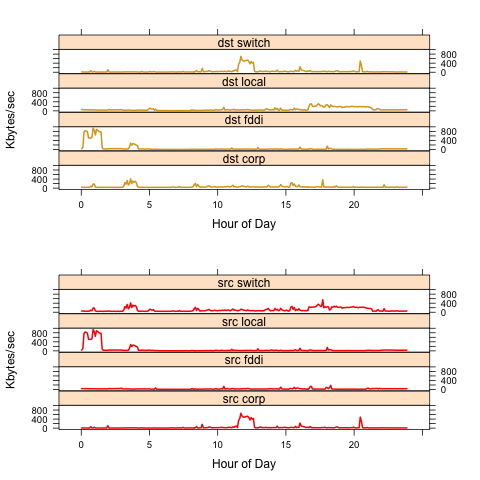

In [43]:
# Generate trellis plots.
print(p.in, position=c(0, 0.5, 1, 1), more=TRUE)
print(p.out, position=c(0, 0, 1, 0.5))

In [44]:
B.full <- rbind(B, 2 - colSums(B))
write.table(format(B.full), row.names=F, col.names=F, quote=F)

1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0
0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0
0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1


In [45]:
x.full <- Z %*% t(B.full)
tomo.fit <- tomogravity(x.full, B.full, 0.01)
zhat <- tomo.fit$Xhat

In [46]:
nt <- nrow(Z); nf <- ncol(Z)
t.dat <- data.frame(z = as.vector(c(Z) / 2^10), zhat = as.vector(c(zhat) / 2^10),
                    t <- c(rep(as.vector(bell.labs$tvec), nf)))

od.names <- c(rep("fddi->fddi", nt), rep("fddi->local", nt), 
              rep("fddi->switch", nt), rep("fddi->corp", nt), 
              rep("local->fddi", nt), rep("local->local", nt), 
              rep("local->switch", nt), rep("local->corp", nt), 
              rep("switch->fddi", nt), rep("switch->local", nt), 
              rep("switch->switch", nt), rep("switch->corp", nt), 
              rep("corp->fddi", nt), rep("corp->local", nt), 
              rep("corp->switch", nt), rep("corp->corp", nt))

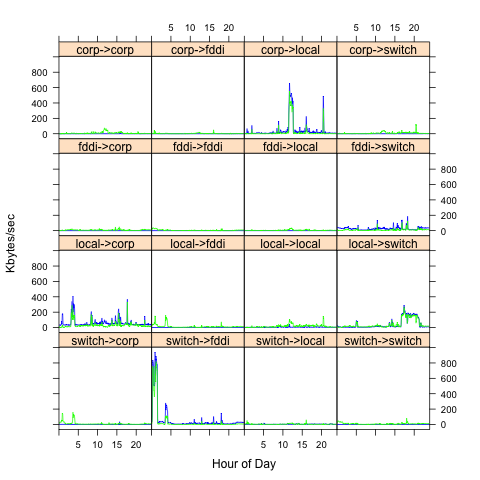

In [47]:
t.dat <- transform(t.dat, OD = od.names)

xyplot(z~t | OD, data=t.dat, panel=function(x, y, subscripts){
    panel.xyplot(x, y, type="l", col.line="blue")
    panel.xyplot(t.dat$t[subscripts], t.dat$zhat[subscripts], type="l", col.line="green")
}, as.table=T, subscripts=T, xlim=c(0, 24), xlab="Hour of Day", ylab="Kbytes/sec")